In [2]:
# !pip install tensorflow==1.15

In [3]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
!unzip SKAB.zip

Archive:  SKAB.zip
  inflating: SKAB/anomaly-free/anomaly-free.csv  
  inflating: SKAB/other/11.csv       
  inflating: SKAB/other/12.csv       
  inflating: SKAB/other/13.csv       
  inflating: SKAB/other/14.csv       
  inflating: SKAB/other/15.csv       
  inflating: SKAB/other/16.csv       
  inflating: SKAB/other/17.csv       
  inflating: SKAB/other/18.csv       
  inflating: SKAB/other/19.csv       
  inflating: SKAB/other/20.csv       
  inflating: SKAB/other/21.csv       
  inflating: SKAB/other/22.csv       
  inflating: SKAB/other/23.csv       
  inflating: SKAB/other/9.csv        
  inflating: SKAB/valve1/0.csv       
  inflating: SKAB/valve1/1.csv       
  inflating: SKAB/valve1/10.csv      
  inflating: SKAB/valve1/11.csv      
  inflating: SKAB/valve1/12.csv      
  inflating: SKAB/valve1/13.csv      
  inflating: SKAB/valve1/14.csv      
  inflating: SKAB/valve1/15.csv      
  inflating: SKAB/valve1/2.csv       
  inflating: SKAB/valve1/3.csv       
  inflating: SKAB/v

In [6]:
DATA_PATH = '/content/SKAB/'

In [7]:
dirs = [os.path.join(DATA_PATH, dir) for dir in os.listdir(DATA_PATH)]
anomaly_dirs = dirs[:3]

In [8]:
anomaly_dirs

['/content/SKAB/valve2', '/content/SKAB/valve1', '/content/SKAB/other']

In [9]:
anomalies_dirs = []
for path in anomaly_dirs:
  files = os.listdir(path)
  for file_ in files:
    anomalies_dirs.append(os.path.join(path, file_))

# Coding time

In [10]:
DATA_TO_GENERATE = '/content/to_generate_path/'


In [12]:
for data_path in anomalies_dirs:
  tmp_data = pd.read_csv(data_path, sep=';', parse_dates=True)
  tmp_data = tmp_data.drop(columns='datetime')
  output_path = data_path.replace('SKAB', 'to_generate_path')
  tmp_data.to_csv(output_path, index=False)

In [13]:
anomalies_dirs = [dir.replace('SKAB', 'to_generate_path') for dir in anomalies_dirs]

# Data Loading

In [14]:
"""
Time-series Generative Adversarial Networks (TimeGAN) Codebase.
"""

import numpy as np



class MinMaxScalerClass():
  def __init__(self, eps = 1e-7):
    self.eps = eps

  def fit_transform(self, data):
    self.min = np.min(data,0)
    self.max = np.max(data,0)
    self.data = data
    numerator = self.data - self.min
    denominator = self.max - self.min
    norm_data = numerator / (denominator + self.eps)
    return norm_data

  def inverse_transform(self, data):
    return data * (self.max - self.min + self.eps) + self.min

def MinMaxScaler(data):
  """Min Max normalizer.
  
  Args:
    - data: original data
  
  Returns:
    - norm_data: normalized data
  """
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  return norm_data


def sine_data_generation (no, seq_len, dim):
  """Sine data generation.
  
  Args:
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
  Returns:
    - data: generated data
  """  
  # Initialize the output
  data = list()

  # Generate sine data
  for i in range(no):      
    # Initialize each time-series
    temp = list()
    # For each feature
    for k in range(dim):
      # Randomly drawn frequency and phase
      freq = np.random.uniform(0, 0.1)            
      phase = np.random.uniform(0, 0.1)
          
      # Generate sine signal based on the drawn frequency and phase
      temp_data = [np.sin(freq * j + phase) for j in range(seq_len)] 
      temp.append(temp_data)
        
    # Align row/column
    temp = np.transpose(np.asarray(temp))        
    # Normalize to [0,1]
    temp = (temp + 1)*0.5
    # Stack the generated data
    data.append(temp)
                
  return data
    

def real_data_loading (data_name, seq_len):
  """Load and preprocess real-world datasets.
  
  Args:
    - data_name: stock or energy
    - seq_len: sequence length
    
  Returns:
    - data: preprocessed data.
  """  
  ori_data = np.loadtxt(data_name, delimiter=",", skiprows=1)
        
  # Flip the data to make chronological data
  ori_data = ori_data[::-1]
  # Normalize the data
  ori_data = MinMaxScaler(ori_data)
    
  # Preprocess the dataset
  temp_data = []    
  # Cut data by sequence length
  for i in range(0, len(ori_data) - seq_len):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))    
  data = []
  for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])
  return data

In [15]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
# from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

# Generating data

In [18]:
# !pip install clearml

In [57]:
# !clearml-init

In [19]:
from clearml import Task

In [21]:
def generate_data(data_path: str, seq_len: int = 24, 
                  model:str = {'gru', 'lstm'}, hidden_dim: int = 12,
                  num_layers: int = 3, iteration: int = 5000,
                  batch_size: int = 128, scaler:str = 'MinMaxScaler') -> tuple:

  # assert model in {'gru', 'lstm'}, print("unknown model")
  
  ori_data = real_data_loading(data_path, seq_len)
  parameters = dict()

  parameters['module'] = model
  parameters['hidden_dim'] = hidden_dim
  parameters['num_layer'] = num_layers
  parameters['iterations'] = iteration
  parameters['batch_size'] = batch_size

  generated_data = timegan(ori_data, parameters)
  scaler = MinMaxScalerClass()
  _ = scaler.fit_transform(ori_data)  
  generated_unscaled_data = scaler.inverse_transform(generated_data)
  task = Task.init("predict_analysis", f"graph{'/'.join(data_path.split('/')[-2:])}")
  visualization(ori_data, generated_data, 'pca')
  visualization(ori_data, generated_data, 'tsne')
  task.close()
  return generated_data, generated_unscaled_data

In [22]:
generated_data = {}
unscaled_generated_data = {}

In [23]:
three_dirs = ['/content/to_generate_path/other/16.csv', 
              '/content/to_generate_path/valve1/3.csv',
              '/content/to_generate_path/valve2/1.csv']

In [ ]:
# for dir in anomalies_dirs:
#   generated, unscaled = generate_data(dir, model='gru')
#   generated_data['/'.join(dir.split('/')[-2:])] = generated
#   unscaled_generated_data['/'.join(dir.split('/')[-2:])] = unscaled





Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons


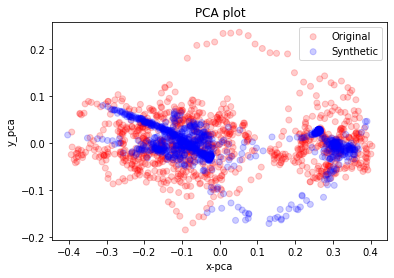

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.244s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.008624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.239174
[t-SNE] KL divergence after 300 iterations: 1.120065


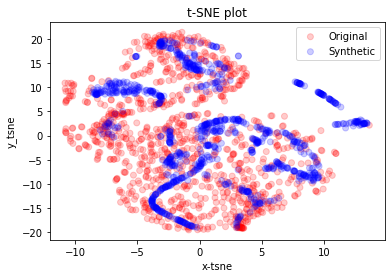


Start Embedding Network Training
step: 0/5000, e_loss: 0.3115
step: 1000/5000, e_loss: 0.1427
step: 2000/5000, e_loss: 0.1231
step: 3000/5000, e_loss: 0.1207
step: 4000/5000, e_loss: 0.1166
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/5000, s_loss: 0.3407
step: 1000/5000, s_loss: 0.0857
step: 2000/5000, s_loss: 0.0848
step: 3000/5000, s_loss: 0.083
step: 4000/5000, s_loss: 0.0852
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/5000, d_loss: 2.0107, g_loss_u: 0.7198, g_loss_s: 0.0777, g_loss_v: 0.424, e_loss_t0: 0.1217
step: 1000/5000, d_loss: 1.1584, g_loss_u: 1.8132, g_loss_s: 0.0796, g_loss_v: 0.0787, e_loss_t0: 0.1089
step: 2000/5000, d_loss: 1.4198, g_loss_u: 1.4375, g_loss_s: 0.0716, g_loss_v: 0.065, e_loss_t0: 0.098
step: 3000/5000, d_loss: 1.4146, g_loss_u: 1.4783, g_loss_s: 0.0656, g_loss_v: 0.0568, e_loss_t0: 0.0956
step: 4000/5000, d_loss: 1.2639, g_loss_u: 1.6703, g_loss_s: 0.0623, g_loss_v: 0.0567, e_loss_t0: 0.0

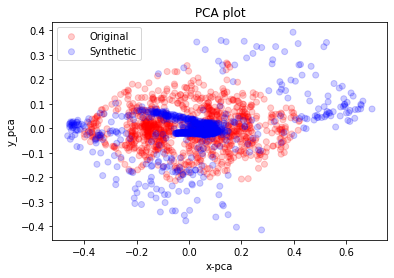

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.212s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.033210
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.212448
[t-SNE] KL divergence after 300 iterations: 1.284649


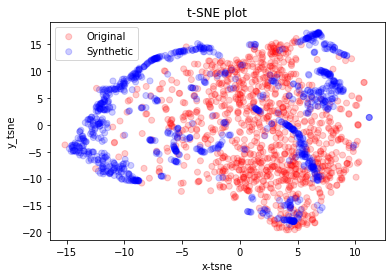

Start Embedding Network Training
step: 0/5000, e_loss: 0.3071
step: 1000/5000, e_loss: 0.1392
step: 2000/5000, e_loss: 0.1257
step: 3000/5000, e_loss: 0.1241
step: 4000/5000, e_loss: 0.1217
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/5000, s_loss: 0.3216
step: 1000/5000, s_loss: 0.0899
step: 2000/5000, s_loss: 0.0875
step: 3000/5000, s_loss: 0.0814
step: 4000/5000, s_loss: 0.0824
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/5000, d_loss: 2.0818, g_loss_u: 0.6501, g_loss_s: 0.0826, g_loss_v: 0.3879, e_loss_t0: 0.1302
step: 1000/5000, d_loss: 1.9081, g_loss_u: 1.1704, g_loss_s: 0.0805, g_loss_v: 0.0771, e_loss_t0: 0.1183
step: 2000/5000, d_loss: 1.7622, g_loss_u: 1.0362, g_loss_s: 0.0853, g_loss_v: 0.0611, e_loss_t0: 0.1154
step: 3000/5000, d_loss: 1.8677, g_loss_u: 1.0906, g_loss_s: 0.0949, g_loss_v: 0.0625, e_loss_t0: 0.1136
step: 4000/5000, d_loss: 1.6529, g_loss_u: 1.3939, g_loss_s: 0.0997, g_loss_v: 0.0642, e_loss_t0: 

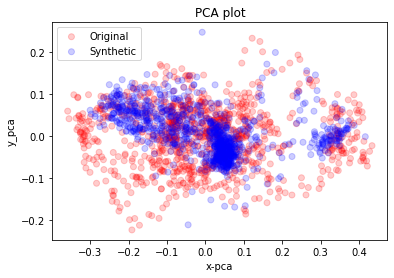

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1942 samples in 0.001s...
[t-SNE] Computed neighbors for 1942 samples in 0.197s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1942
[t-SNE] Computed conditional probabilities for sample 1942 / 1942
[t-SNE] Mean sigma: 0.073095
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.979256
[t-SNE] KL divergence after 300 iterations: 2.074987


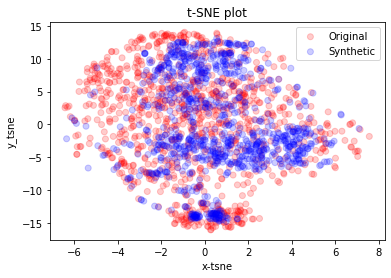

In [24]:
for dir in three_dirs:
  generated, unscaled = generate_data(dir, model='gru')
  generated_data['/'.join(dir.split('/')[-2:])] = generated
  unscaled_generated_data['/'.join(dir.split('/')[-2:])] = unscaled

## DATA UPLOADING

In [107]:
scales={}

In [108]:
names_scaled = ['(scaled)graphother_22.txt', 
                '(scaled)graphvalve1_14.txt',
                '(scaled)graphvalve2_3.txt'
]
names_unscaled = ['(unscaled)graphother_22.txt',
                  '(unscaled)graphvalve1_14.txt',
                  '(unscaled)graphvalve2_3.txt'
]

In [109]:
for generated, name in zip(generated_data, names_scaled):
  scales[name] = generated_data[generated].shape
for generated, name in zip(unscaled_generated_data, names_unscaled):
  scales[name] = generated_data[generated].shape

In [110]:
scales

{'(scaled)graphother_22.txt': (1055, 24, 10),
 '(scaled)graphvalve1_14.txt': (1115, 24, 10),
 '(scaled)graphvalve2_3.txt': (971, 24, 10),
 '(unscaled)graphother_22.txt': (1055, 24, 10),
 '(unscaled)graphvalve1_14.txt': (1115, 24, 10),
 '(unscaled)graphvalve2_3.txt': (971, 24, 10)}

In [111]:
names

['(scaled)graphother_22.txt',
 '(unscaled)graphother_22.txt',
 '(scaled)graphvalve1_14.txt',
 '(unscaled)graphvalve1_14.txt',
 '(scaled)graphvalve2_3.txt',
 '(unscaled)graphvalve2_3.txt']

In [64]:
for it in scales:
  print(type(scales[it]))

<class 'list'>
<class 'list'>
<class 'list'>


In [112]:
json_data = {'names': names, 
             'names_scaled': names_scaled, 
             'names_unscaled': names_unscaled,
             'scales': scales}
json_data = json.dumps(json_data)

# open file for writing, "w" 
f = open("help.json","w")

# write json object to file
f.write(json_data)

# close file
f.close()

In [67]:
import json

In [85]:
f = open('help.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
# Iterating through the json
# list
print(data['scales'])  
# Closing file
f.close()

{'other/22.csv': [1055, 24, 10], 'valve1/14.csv': [1115, 24, 10], 'valve2/3.csv': [971, 24, 10]}


In [86]:
names

['(scaled)graphother_22.txt',
 '(unscaled)graphother_22.txt',
 '(scaled)graphvalve1_14.txt',
 '(unscaled)graphvalve1_14.txt',
 '(scaled)graphvalve2_3.txt',
 '(unscaled)graphvalve2_3.txt']

In [114]:
def load_data(json_file: str='/content/help.json') -> dict:
  global names, scales
  f = open(json_file)
  data = json.load(f)
  names = data['names']
  names_scaled = data['names_scaled']
  names_unscaled = data['names_unscaled']
  scales = data['scales']
  arrays = {}
  for name in names:
    loaded_arr = np.loadtxt(name)
  
    arrays[name] = loaded_arr.reshape(
        loaded_arr.shape[0], loaded_arr.shape[1] // scales[name][2], scales[name][2])
  f.close()
  return arrays
  

In [115]:
check = load_data()

In [41]:
names = []
for generated, unscaled in zip(generated_data, unscaled_generated_data):
  tmp_scaled = np.array(generated_data[generated])
  tmp_unscaled = np.array(unscaled_generated_data[unscaled])
  names.append(f"(scaled)graph{'_'.join(generated.split('/')[-2:])}".replace('csv', 'txt'))
  names.append(f"(unscaled)graph{'_'.join(unscaled.split('/')[-2:])}".replace('csv', 'txt'))
  np.savetxt(f"(scaled)graph{'_'.join(generated.split('/')[-2:])}".replace('csv', 'txt'),
             tmp_scaled.reshape(tmp_scaled.shape[0], -1))
  np.savetxt(f"(unscaled)graph{'_'.join(unscaled.split('/')[-2:])}".replace('csv', 'txt'),
             tmp_unscaled.reshape(tmp_unscaled.shape[0], -1))

In [43]:
check = np.loadtxt("(scaled)graphother_22.txt")
load_original_arr = check.reshape(
    check.shape[0], check.shape[1] // arr.shape[2], arr.shape[2])

In [32]:
generated_data

{'other/22.csv': array([[[7.14900830e-01, 5.23050246e-01, 6.57311082e-03, ...,
          1.38468206e-01, 5.06639430e-07, 0.00000000e+00],
         [6.41561643e-01, 4.76439929e-01, 5.70994615e-03, ...,
          8.46996903e-03, 5.96046388e-08, 2.98023194e-08],
         [7.46787194e-01, 6.06849319e-01, 6.54307008e-03, ...,
          4.45578098e-02, 1.78813916e-07, 0.00000000e+00],
         ...,
         [7.99537626e-01, 7.68404762e-01, 7.94526934e-03, ...,
          1.37504637e-02, 2.98023194e-08, 0.00000000e+00],
         [7.99640206e-01, 7.70655666e-01, 8.00508260e-03, ...,
          1.41585171e-02, 2.98023194e-08, 0.00000000e+00],
         [7.99598244e-01, 7.72709279e-01, 8.06412100e-03, ...,
          1.46732330e-02, 8.94069582e-08, 0.00000000e+00]],
 
        [[2.72886843e-01, 3.16760387e-01, 7.49436021e-03, ...,
          9.86849605e-01, 9.99918003e-01, 1.58548339e-05],
         [2.30490571e-01, 2.56888699e-01, 6.66412711e-03, ...,
          9.88857507e-01, 9.99953051e-01, 1.439452

In [ ]:
valve1_data = [pd.read_csv(os.path.join(DATA_PATH, file), sep=';', parse_dates=True) for file in fi]

In [ ]:
df = valve1_data[0]
df.datetime = 0
for i in (1, len(valve1_data)-1):
    valve1_data[i].datetime = i
    df = pd.concat([df, valve1_data[i]])

In [ ]:
df.to_csv('check.csv', index=False)

In [ ]:
data_name = 'check.csv'
seq_len = 24

ori_data = real_data_loading(data_name, seq_len)
print(data_name + ' dataset is ready.')

check.csv dataset is ready.


In [ ]:
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 10000
parameters['batch_size'] = 128

In [ ]:
# Run TimeGAN
generated_data = timegan(ori_data, parameters)   
print('Finish Synthetic Data Generation')





Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons


In [ ]:
from sklearn.preprocessing import MinMaxScaler as mms

In [ ]:
generated_data.shape

(3419, 24, 11)

In [ ]:
generated_data

array([[[5.25649484e-02, 8.12819832e-01, 2.82980327e-01, ...,
         1.29299488e-01, 9.99999781e-01, 3.30805745e-06],
        [2.84831224e-02, 9.05662388e-01, 4.28725952e-01, ...,
         4.62441075e-01, 9.99999304e-01, 1.60932525e-06],
        [4.29214832e-02, 8.13736584e-01, 4.90981404e-01, ...,
         5.39514945e-01, 9.99999304e-01, 6.25461277e-04],
        ...,
        [7.33021493e-02, 7.67672804e-01, 4.34050471e-01, ...,
         7.85043458e-01, 9.99998589e-01, 4.17232472e-07],
        [8.92437094e-02, 7.39800177e-01, 4.22549213e-01, ...,
         5.53759442e-01, 9.99999542e-01, 0.00000000e+00],
        [7.26951654e-02, 7.99011575e-01, 4.33337726e-01, ...,
         6.66828258e-01, 9.99999542e-01, 6.55651027e-07]],

       [[7.40638072e-02, 7.53372049e-01, 4.90373443e-01, ...,
         7.58454602e-01, 0.00000000e+00, 0.00000000e+00],
        [7.15773101e-02, 5.08160061e-01, 4.41090366e-01, ...,
         7.44336884e-01, 2.08616236e-07, 0.00000000e+00],
        [6.55727382e-02, 

array([[7.88474227e-01, 2.82826677e-02, 4.05706007e-02, ...,
        2.95170169e+01, 9.99999781e-01, 3.30805745e-06],
       [4.27246836e-01, 2.85944237e-02, 4.20449489e-02, ...,
        3.08491169e+01, 9.99999304e-01, 1.60932525e-06],
       [6.43822248e-01, 2.82857461e-02, 4.26747188e-02, ...,
        3.11573045e+01, 9.99999304e-01, 6.25461277e-04],
       ...,
       [1.11230671e+00, 2.77517220e-02, 4.25891082e-02, ...,
        3.19285596e+01, 1.78813916e-07, 0.00000000e+00],
       [1.09469979e+00, 2.81564557e-02, 4.20679378e-02, ...,
        3.19862390e+01, 8.94069582e-08, 0.00000000e+00],
       [1.15102618e+00, 2.82699380e-02, 4.12839722e-02, ...,
        3.19788742e+01, 8.94069582e-08, 0.00000000e+00]])

In [ ]:
with open('test.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(generated_data.shape))
    
    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in generated_data:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.2f')

        # Writing out a break to indicate different slices...
        outfile.write('# New slice\n')

In [ ]:
pd.DataFrame(scaler.inverse_transform(generated_data.reshape(-1, 11)))

,0,1,2,3,4,5,6,7,8,9,10
0,0.788474,0.028283,0.040571,0.388229,-0.448193,69.596116,24.923687,208.370857,29.517017,9.999998e-01,0.000003
1,0.427247,0.028594,0.042045,0.388229,-0.278181,68.413305,24.798171,214.200676,30.849117,9.999993e-01,0.000002
2,0.643822,0.028286,0.042675,0.388306,-0.128497,68.521710,24.797265,223.848262,31.157304,9.999993e-01,0.000625
3,0.494669,0.028524,0.042098,0.445744,0.059493,67.999582,24.812459,236.155364,32.974523,9.999574e-01,0.000017
4,0.570174,0.028510,0.042942,0.426734,-0.312280,68.186204,24.818323,220.583608,32.524543,9.999919e-01,0.000018
...,...,...,...,...,...,...,...,...,...,...,...
82051,1.238291,0.028326,0.040681,0.388264,0.057510,67.933229,24.753300,234.186956,31.998493,1.490116e-07,0.000000
82052,1.115702,0.028223,0.041933,0.388257,0.066949,67.911021,24.749942,236.385071,31.984333,8.940696e-08,0.000000
82053,1.112307,0.027752,0.042589,0.388229,0.250360,67.920810,24.749026,232.456983,31.928560,1.788139e-07,0.000000
82054,1.094700,0.028156,0.042068,0.388236,0.215354,67.963256,24.749827,233.305111,31.986239,8.940696e-08,0.000000


In [ ]:
pd.read_csv('check.csv').shape

(3443, 11)

In [36]:
!clearml-init 

ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
api {    # Sergei Simonov's workspace    web_server: https://app.clear.ml    api_server: https://api.clear.ml    files_server: https://files.clear.ml    credentials {      "access_key" = "G79DK0YL497F1ZM5KAHC"      "secret_key" = "gNFM8aDl982tibDpbCFBFGBxubU56UpPzZWvYsfE7IR5fXl2yB"    }  }
Detected credentials key="G79DK0YL497F1ZM5KAHC" secret="gNFM***"
WEB Host configured to: [https://app.clear.ml] 
API Host configured to: [https://api.clear.ml] 
File Store Host configured to: [https://files.clear.ml] 

ClearML Hosts configuration:
Web App: https://app.clear.ml
API: https://api.clear.ml
File Store: https:

ClearML Task: created new task id=3dbd3cd2b9e64734b8e675347c102b16
ClearML results page: https://app.clear.ml/projects/9105a581d4b14101b23a61c14a69434e/experiments/3dbd3cd2b9e64734b8e675347c102b16/output/log
2022-05-24 20:56:59,332 - clearml.Task - INFO - No repository found, storing script code instead


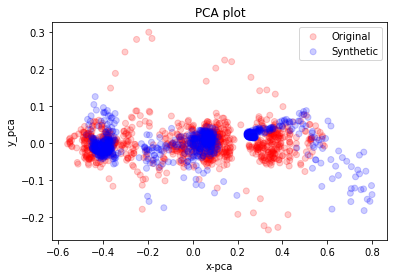

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.022730
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.674934
[t-SNE] KL divergence after 300 iterations: 1.288257


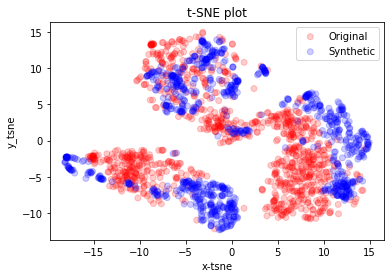